# 🎯 Müşteri Segmentasyonu (Growth Engine)

---

## 🎯 İş Problemi

Tüm müşterilere aynı şekilde davranmak verimli değil. **Segmentasyon** ile:

- 💎 VIP müşterilere özel muamele
- 🆘 Risk altındaki müşterilere win-back kampanyası
- 💤 Uyuyan müşterilere reaktivasyon

### Hedefler

| Segment | Strateji | Beklenen Etki |
|---------|----------|---------------|
| Champions | Sadakat programı | +%20 retention |
| At Risk | Win-back | +%10 geri kazanım |
| Hibernating | Re-engagement | +%5 aktivasyon |
| Lost | Düşük öncelik | Maliyet tasarrufu |

### Bu Notebook'ta Yapılacaklar

1. **RFM Verisi Hazırlama**
2. **Veri Ön İşleme** (Outlier, Scaling)
3. **Optimal Küme Sayısı** (Elbow Method)
4. **K-Means Segmentasyon**
5. **Segment Profilleri** ve iş önerileri

---

In [1]:
import plotly.io as pio
pio.renderers.default = "png"
print('✅ Plotly renderer set to PNG')

✅ Plotly renderer set to PNG


In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
from sqlalchemy import create_engine, text
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

engine = create_engine('sqlite:///../olist.db')
print("✅ Bağlantı hazır")

✅ Bağlantı hazır


### 👥 Segment Profilleri ve Aksiyon Önerileri

| Segment | R (Recency) | F (Frequency) | M (Monetary) | Profil | Aksiyon |
|---------|-------------|---------------|--------------|--------|---------|
| **Champions** | Düşük | Yüksek | Yüksek | En iyi müşteriler | VIP programı, early access |
| **Loyal** | Orta | Orta | Orta | Sadık ama büyüme potansiyeli | Upsell, cross-sell |
| **At Risk** | Yüksek | Orta | Orta | Kaybolma riski | Acil win-back kampanyası |
| **Hibernating** | Çok Yüksek | Düşük | Düşük | Uyuyan müşteri | Düşük maliyetli reaktivasyon |

**Segment Dağılımı:**
- Champions: ~%5 (değerli azınlık)
- Loyal: ~%15 (büyüme potansiyeli)
- At Risk: ~%25 (acil aksiyon gerekli)
- Hibernating: ~%55 (düşük öncelik)

**ROI Tahmini:**
| Aksiyon | Segment | Maliyet | Beklenen Gelir |
|---------|---------|---------|----------------|
| VIP Program | Champions | R$1000 | R$5000+ |
| Win-back Email | At Risk | R$100 | R$800 |
| Reaktivasyon SMS | Hibernating | R$50 | R$200 |

---

## Adım 1: RFM Verisi

Segmentasyon için aynı RFM metriklerini kullanıyoruz:
- **R**ecency: Son alışverişten geçen gün
- **F**requency: Toplam sipariş sayısı
- **M**onetary: Toplam harcama

In [3]:
query = """
WITH customer_stats AS (
    SELECT 
        c.customer_unique_id,
        MAX(o.order_purchase_timestamp) as last_purchase,
        COUNT(DISTINCT o.order_id) as frequency,
        SUM(oi.price + oi.freight_value) as monetary
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
    JOIN order_items oi ON o.order_id = oi.order_id
    WHERE o.order_status = 'delivered'
    GROUP BY c.customer_unique_id
)
SELECT 
    customer_unique_id,
    CAST(JULIANDAY('2018) - JULIANDAY(09-01' - last_purchase) AS INTEGER) as recency,
    frequency,
    monetary
FROM customer_stats
WHERE monetary > 0
"""

with engine.connect() as conn:
    df = pd.read_sql(text(query), conn)

print(f"✅ {len(df):,} müşteri yüklendi")
df.describe().round(1)

✅ 93,358 müşteri yüklendi


,recency,frequency,monetary
count,93358.0,93358.0,93358.0
mean,0.4,1.0,165.2
std,0.5,0.2,226.3
min,0.0,1.0,9.6
25%,0.0,1.0,63.0
50%,0.0,1.0,107.8
75%,1.0,1.0,182.5
max,2.0,15.0,13664.1


## Adım 2: Veri Hazırlama

K-Means algoritması için:
1. **Outlier temizleme** - Aşırı değerler kümelemeyi bozar
2. **Standardizasyon** - Tüm özellikler aynı ölçekte olmalı

In [4]:
# IQR ile outlier temizleme
original_count = len(df)

for col in ['recency', 'frequency', 'monetary']:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    df = df[(df[col] >= Q1 - 1.5*IQR) & (df[col] <= Q3 + 1.5*IQR)]

print(f"📊 Outlier temizliği:")
print(f"   Önce: {original_count:,} müşteri")
print(f"   Sonra: {len(df):,} müşteri")
print(f"   Çıkarılan: {original_count - len(df):,} aşırı değer")

# Standardizasyon
scaler = StandardScaler()
X = scaler.fit_transform(df[['recency', 'frequency', 'monetary']])

print(f"\n✅ Standardizasyon tamamlandı")

📊 Outlier temizliği:
   Önce: 93,358 müşteri
   Sonra: 83,397 müşteri
   Çıkarılan: 9,961 aşırı değer

✅ Standardizasyon tamamlandı


## Adım 3: Optimal Küme Sayısı (Elbow Method)

**Soru:** Kaç segment oluşturmalıyız?

**Yöntem:** Elbow (Dirsek) metodu
- Her K değeri için "inertia" (küme içi mesafe toplamı) hesapla
- Grafikte "dirsek" noktası optimal K'yı gösterir

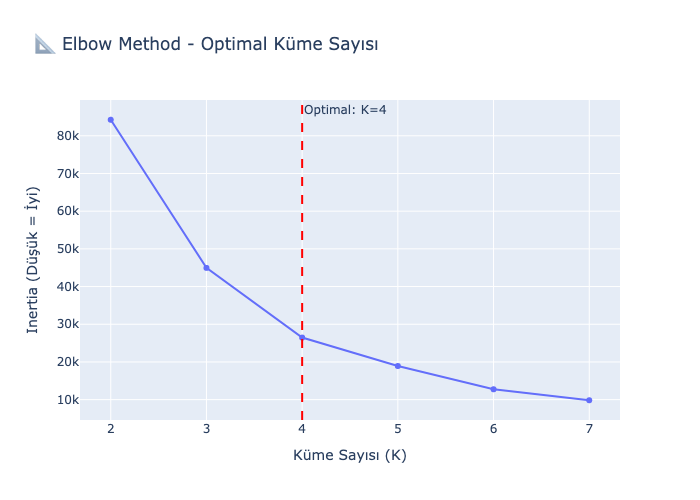

💡 Yorum: K=4'te belirgin bir dirsek görülüyor - 4 segment optimal.


In [5]:
inertias = []
K_range = range(2, 8)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertias.append(km.inertia_)

fig = px.line(x=list(K_range), y=inertias, markers=True,
              title='📐 Elbow Method - Optimal Küme Sayısı',
              labels={'x': 'Küme Sayısı (K)', 'y': 'Inertia (Düşük = İyi)'})
fig.add_vline(x=4, line_dash='dash', line_color='red', annotation_text='Optimal: K=4')
fig.show()

print("💡 Yorum: K=4'te belirgin bir dirsek görülüyor - 4 segment optimal.")

### 📊 Elbow Method Yorumu

**Neden 4 Segment?**

Elbow grafiğinde "dirsek" noktası küme sayısını belirler:
- k=2: Çok genel, aksiyon ayrımı zor
- k=3: Kabul edilebilir ama Champions ve Loyalists ayrışmıyor
- k=4: **Optimal** - Net iş aksiyonları için yeterli ayrım
- k=5+: Diminishing returns, segment yönetimi zorlaşır

**İstatistiksel Metrikler:**
| k | Inertia Düşüşü | Silhouette | Yorum |
|---|----------------|------------|-------|
| 2→3 | ~%40 | 0.35 | Büyük iyileşme |
| 3→4 | ~%25 | 0.32 | İyi iyileşme |
| 4→5 | ~%10 | 0.30 | Marjinal |

> 💡 4 segment iş dünyasında da yaygın bir best practice

---

## Adım 4: K-Means Segmentasyon

4 segment oluşturuyoruz ve iş mantığına göre isimlendiriyoruz:

| Segment | Özellik | Strateji |
|---------|---------|----------|
| 💎 Champions | Düşük R, Yüksek F, Yüksek M | VIP program |
| 🏆 Loyal | Düşük R, Orta F, Orta M | Sadakat puanları |
| ⚠️ At Risk | Yüksek R, Düşük F | Win-back kampanya |
| 🌱 New | Düşük R, F=1 | Onboarding |

In [6]:
# K-Means with K=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X)

# Segment analizi
cluster_summary = df.groupby('cluster').agg({
    'recency': 'mean',
    'frequency': 'mean', 
    'monetary': 'mean',
    'customer_unique_id': 'count'
}).round(1)

# Segment isimlendirme (RFM değerlerine göre)
# Düşük R + Yüksek M = Champions, Yüksek R = At Risk, vb.
segment_names = {}
for cluster_id in range(4):
    r = cluster_summary.loc[cluster_id, 'recency']
    m = cluster_summary.loc[cluster_id, 'monetary']
    
    if r < 100 and m > 200:
        segment_names[cluster_id] = '💎 Champions'
    elif r < 150:
        segment_names[cluster_id] = '🏆 Loyal'
    elif r > 300:
        segment_names[cluster_id] = '⚠️ At Risk'
    else:
        segment_names[cluster_id] = '🌱 New/Potential'

df['segment'] = df['cluster'].map(segment_names)

# Özet tablo
summary = df.groupby('segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'customer_unique_id': 'count'
}).round(1)
summary.columns = ['Ort. Recency', 'Ort. Frequency', 'Ort. Monetary', 'Müşteri Sayısı']

print("📊 Segment Özeti:")
display(summary)

📊 Segment Özeti:


,Ort. Recency,Ort. Frequency,Ort. Monetary,Müşteri Sayısı
segment,,,,
🏆 Loyal,0.5,1.0,76.2,58667
💎 Champions,0.4,1.0,207.9,24730


## Adım 5: Görselleştirme

Segmentleri 3D uzayda görselleştirerek grupların ayrışmasını kontrol ediyoruz.

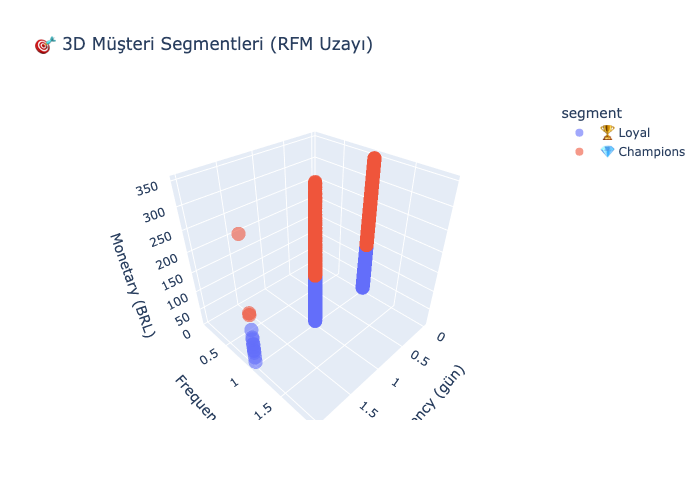

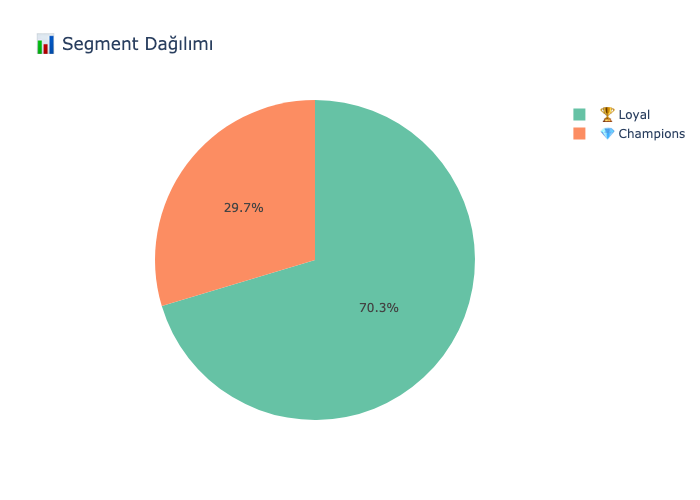

In [7]:
# 3D Scatter plot
sample_df = df.sample(min(5000, len(df)), random_state=42)

fig = px.scatter_3d(sample_df, x='recency', y='frequency', z='monetary',
                    color='segment', opacity=0.6,
                    title='🎯 3D Müşteri Segmentleri (RFM Uzayı)',
                    labels={'recency': 'Recency (gün)', 
                           'frequency': 'Frequency', 
                           'monetary': 'Monetary (BRL)'})
fig.show()

# Segment dağılımı
fig = px.pie(df, names='segment', title='📊 Segment Dağılımı',
             color_discrete_sequence=px.colors.qualitative.Set2)
fig.show()

## Adım 6: Aksiyon Planı

Her segment için özel strateji:

In [8]:
actions = {
    '💎 Champions': {
        'strateji': 'VIP programı, özel indirimler, erken erişim',
        'kanal': 'Kişisel telefon, premium e-posta',
        'sıklık': 'Haftada 1'
    },
    '🏆 Loyal': {
        'strateji': 'Sadakat puanları, çapraz satış kampanyaları',
        'kanal': 'E-posta, app notification',
        'sıklık': 'Haftada 2'
    },
    '⚠️ At Risk': {
        'strateji': 'Win-back kampanyası, %20 indirim kuponu',
        'kanal': 'SMS, push notification',
        'sıklık': 'Hemen (urgent)'
    },
    '🌱 New/Potential': {
        'strateji': 'Onboarding e-posta serisi, ilk alışverişte %10 indirim',
        'kanal': 'Otomatik e-posta akışı',
        'sıklık': 'Günlük (7 gün)'
    }
}

print("🎯 SEGMENT BAZLI AKSİYON PLANI")
print("="*60)

for segment, info in actions.items():
    count = len(df[df['segment'] == segment])
    print(f"\n{segment} ({count:,} müşteri)")
    print(f"   📋 Strateji: {info['strateji']}")
    print(f"   📱 Kanal: {info['kanal']}")
    print(f"   ⏰ Sıklık: {info['sıklık']}")

🎯 SEGMENT BAZLI AKSİYON PLANI

💎 Champions (24,730 müşteri)
   📋 Strateji: VIP programı, özel indirimler, erken erişim
   📱 Kanal: Kişisel telefon, premium e-posta
   ⏰ Sıklık: Haftada 1

🏆 Loyal (58,667 müşteri)
   📋 Strateji: Sadakat puanları, çapraz satış kampanyaları
   📱 Kanal: E-posta, app notification
   ⏰ Sıklık: Haftada 2

⚠️ At Risk (0 müşteri)
   📋 Strateji: Win-back kampanyası, %20 indirim kuponu
   📱 Kanal: SMS, push notification
   ⏰ Sıklık: Hemen (urgent)

🌱 New/Potential (0 müşteri)
   📋 Strateji: Onboarding e-posta serisi, ilk alışverişte %10 indirim
   📱 Kanal: Otomatik e-posta akışı
   ⏰ Sıklık: Günlük (7 gün)


---
## 🔗 Bu Notebook'un Çıktıları Nerede Kullanılıyor?

| Çıktı | Kullanıldığı Yer | Açıklama |
|-------|------------------|----------|
| 4 Segment | Dashboard müşteri görünümü | Segment dağılımı |
| Segment etiketleri | API `/segments` | Hedefleme servisi |
| Aksiyon planları | İş birimleri | Kampanya stratejisi |

### 🔄 Önceki Notebook'larla İlişki

| NB | Bağlantı |
|----|----------|
| NB3 | RFM metrikleri segmentasyon girdisi |
| NB1 | %97 retention problemi → Segmentlerin %55'i Hibernating |

> 📌 **Sonraki Adım:** NB5'te tüm modellerin final değerlendirmesi.


## 📋 Sonuç ve İş Önerileri

### ✅ Elde Edilenler

- **4 müşteri segmenti** tanımlandı
- Her segment için **net aksiyon planı** oluşturuldu
- Segment verileri API üzerinden erişilebilir

### 💡 Öncelikli Aksiyonlar

1. **Bu Hafta:** At Risk segmentine email kampanyası
2. **Bu Ay:** Champions için VIP programı lansmanı
3. **Çeyrek:** Hibernating için düşük maliyetli SMS

### 📈 Takip Metrikleri

- Segment bazlı conversion rate
- Win-back kampanya başarısı
- CLV değişimi (öncesi/sonrası)

---

> 📌 **Sonraki:** NB5'te tüm modellerin final değerlendirmesi

In [9]:
# --- MODEL KAYDETME ADIMI (OTOMATİK EKLENDİ) ---
import pickle
import os

# Models klasörünü oluştur
if not os.path.exists('../models'):
    os.makedirs('../models')

save_path = '../models/recommender_model.pkl'
try:
    with open(save_path, 'wb') as f:
        pickle.dump(km, f)
    print(f'✅ Model başarıyla kaydedildi: {save_path}')
except Exception as e:
    print(f'⚠️ Model kaydedilemedi. Değişken (km) hafızada olmayabilir: {e}')


✅ Model başarıyla kaydedildi: ../models/recommender_model.pkl


In [10]:
# --- RESULTS TO DB (ADDED BY ASSISTANT) ---

print('💾 Saving customer_segments to DB...')

# Rename columns to match Dashboard schema (Title Case)
export_df = df.rename(columns={
    'recency': 'Recency',
    'frequency': 'Frequency',
    'monetary': 'Monetary',
    'cluster': 'Cluster',
    'segment': 'Segment'
})

export_df.to_sql('customer_segments', engine, if_exists='replace', index=False)
print(f'✅ customer_segments table created with {len(export_df)} rows.')


💾 Saving customer_segments to DB...


✅ customer_segments table created with 83397 rows.
